In [9]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
import bayesflow as beef
import tensorflow as tf
from tensorflow.keras.backend import clear_session

import sys
sys.path.append("../")
from experiment import ModelComparisonExperiment

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from scipy.stats import binom, median_abs_deviation
from sklearn.metrics import confusion_matrix, r2_score
import matplotlib.pyplot as plt

In [15]:
NUM_MODELS = 4
ENSEMBLE_SIZE = 10
SIMULATION_PER_MODEL = 10000
CHUNCK_SIZE = 200
MODEL_NAMES = [
    'Random walk', 'Mixture random walk',
    'Levy flight', 'Regime switching'
    ]

model_indices = tf.one_hot(np.tile(np.repeat(
    [0, 1, 2, 3], CHUNCK_SIZE), int((SIMULATION_PER_MODEL/CHUNCK_SIZE))), NUM_MODELS
    )

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [11]:
model_probs_per_ensemble = np.load('../data/validation_model_probs_per_ensemble.npy')

In [12]:
average_model_probs = model_probs_per_ensemble.mean(axis=0)

In [19]:
average_model_probs.shape

(40000, 4)

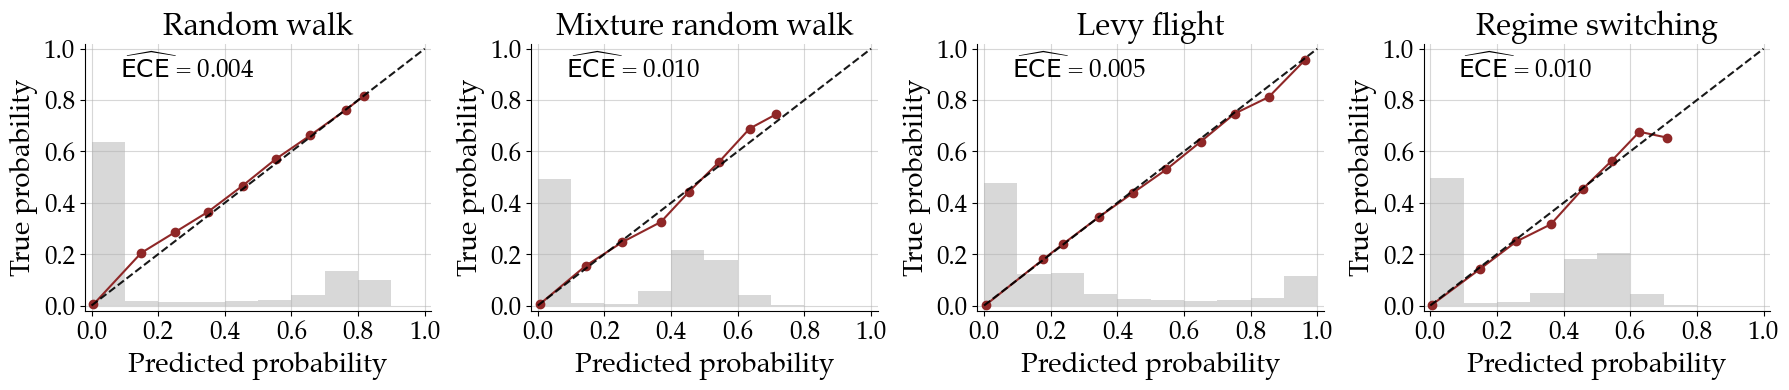

In [16]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=model_indices,
    pred_models=average_model_probs,
    model_names=MODEL_NAMES,
    fig_size=(18, 4),
    title_fontsize=22,
    label_fontsize=20,
    tick_fontsize=18,
    legend_fontsize=18
    )

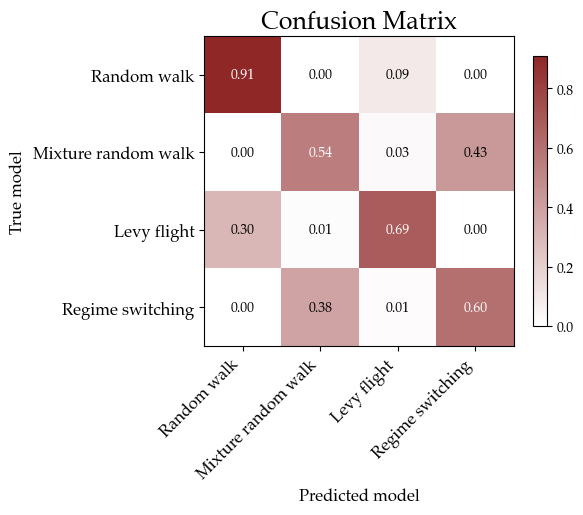

In [17]:
confusion_matrix = beef.diagnostics.plot_confusion_matrix(
    model_indices,
    average_model_probs,
    model_names=MODEL_NAMES,
    xtick_rotation=45,
    ytick_rotation=0
    )

In [ ]:
MODEL_NAMES= [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [ ]:
NUM_MODELS = 4
ENSEMBLE_SIZE = 10
SIMULATION_PER_MODEL = 10000
CHUNCK_SIZE = 200
MODEL_NAMES = [
    'Random walk DDM', 'Mixture random walk DDM',
    'Levy flight DDM', 'Regime switching DDM'
    ]

with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

configurator = beef.configuration.DefaultModelComparisonConfigurator(NUM_MODELS)

model_indices = tf.one_hot(np.tile(np.repeat(
    [0, 1, 2, 3], CHUNCK_SIZE), int((SIMULATION_PER_MODEL/CHUNCK_SIZE))), NUM_MODELS
    )

def get_model_probablities(trainer):
    model_probs = np.zeros((int(SIMULATION_PER_MODEL*NUM_MODELS), NUM_MODELS))
    chunks = np.arange(0, SIMULATION_PER_MODEL+1, CHUNCK_SIZE)
    for i in range(len(chunks)-1):
        sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
        sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}

        tmp_validation_data = {
            'model_outputs': [sim_1, sim_2, sim_3, sim_4],
            'model_indices': validation_data['model_indices']
        }

        tmp_validation_data_configured = configurator(tmp_validation_data)
        with tf.device('/cpu:0'):
            model_probs[(chunks[i]*NUM_MODELS):(chunks[i+1]*NUM_MODELS)] = trainer.amortizer.posterior_probs(
                tmp_validation_data_configured
            )
    return model_probs

In [ ]:
i = 0
trainer = ModelComparisonExperiment(
        checkpoint_path=f'../checkpoints/ensemble_{i}'
        )

In [ ]:
model_probs_per_ensemble = np.zeros((ENSEMBLE_SIZE, SIMULATION_PER_MODEL*NUM_MODELS, NUM_MODELS))

In [ ]:
model_probs_per_ensemble[0] = get_model_probablities(trainer)

In [ ]:
model_probs = np.zeros((int(SIMULATION_PER_MODEL*NUM_MODELS), NUM_MODELS))
chunks = np.arange(SIMULATION_PER_MODEL+1, CHUNCK_SIZE)
chunks
# for i in range(len(chunks)-1):
#     sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
#     sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}

#     tmp_validation_data = {
#         'model_outputs': [sim_1, sim_2, sim_3, sim_4],
#         'model_indices': validation_data['model_indices']
#     }

#     tmp_validation_data_configured = configurator(tmp_validation_data)
#     with tf.device('/cpu:0'):
#         model_probs[(chunks[i]*NUM_MODELS):(chunks[i+1]*NUM_MODELS)] = trainer.amortizer.posterior_probs(
#             tmp_validation_data_configured
#         )

In [ ]:
ENSEMBLE_SIZE = 10

In [ ]:
for i in range(ENSEMBLE_SIZE):
    # initialize trainer
    experiment = ModelComparisonExperiment(
        checkpoint_path=f'checkpoints/ensemble_{i}'
        )
    # read training and validation data
    with open('../data/training_data.pkl', 'rb') as f:
        training_data = pickle.load(f)
    with open('../data/training_validation_data.pkl', 'rb') as f:
        training_validation_data = pickle.load(f)
    # start training
    history = experiment.run(
        training_data=training_data,
        validation_data=training_validation_data
    )

# Validation

In [ ]:
with open('../data/validation_data.pkl', 'rb') as f:
    validation_data = pickle.load(f)

In [ ]:
validation_data['model_outputs'][3]['sim_data'].shape

In [ ]:
configurator = beef.configuration.DefaultModelComparisonConfigurator(4)

In [ ]:
model_probs = np.zeros((40000, 4))
chunks = np.arange(0, 10001, 200)
for i in range(len(chunks)-1):
    sim_1 = {'sim_data': validation_data['model_outputs'][0]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_2 = {'sim_data': validation_data['model_outputs'][1]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_3 = {'sim_data': validation_data['model_outputs'][2]['sim_data'][chunks[i]:chunks[i+1]]}
    sim_4 = {'sim_data': validation_data['model_outputs'][3]['sim_data'][chunks[i]:chunks[i+1]]}
    
    tmp_validation_data = {
        'model_outputs': [sim_1, sim_2, sim_3, sim_4],
        'model_indices': validation_data['model_indices']
    }
    
    tmp_validation_data_configured = configurator(tmp_validation_data)
    with tf.device('/cpu:0'):
        model_probs[(chunks[i]*4):(chunks[i+1]*4)] = experiment.amortizer.posterior_probs(
            tmp_validation_data_configured
        )

In [ ]:
model_indices = tf.one_hot(np.tile(np.repeat([0, 1, 2, 3], 200), 50), 4)

In [ ]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=model_indices,
    pred_models=model_probs,
    model_names=['Random walk',
                 'Mixture random walk',
                 'Levy flight',
                 'Regime switching'],
    fig_size=(14, 3)
)

In [ ]:
model_indices = np.load("model_indices.npy")
model_probs = np.load("model_probs.npy")

In [ ]:
cal_curves = beef.diagnostics.plot_calibration_curves(
    true_models=model_indices,
    pred_models=model_probs,
    model_names=MODEL_NAMES,
    fig_size=(18, 4),
    title_fontsize=22,
    label_fontsize=20,
    tick_fontsize=18,
    legend_fontsize=18
    )

cal_curves.savefig("../plots/calibration_curves.pdf", dpi=300, bbox_inches="tight")

In [ ]:



def plot_confusion_matrix(
    true_models,
    pred_models,
    model_names=None,
    fig_size=(5, 5),
    title_fontsize=18,
    label_fontsize=16,
    tick_fontsize=14,
    value_fontsize=1,
    xtick_rotation=None,
    ytick_rotation=None,
    normalize=True,
    cmap=None,
    title=True,
):
    """Plots a confusion matrix for validating a neural network trained for Bayesian model comparison.

    Parameters
    ----------
    true_models    : np.ndarray of shape (num_data_sets, num_models)
        The one-hot-encoded true model indices per data set.
    pred_models    : np.ndarray of shape (num_data_sets, num_models)
        The predicted posterior model probabilities (PMPs) per data set.
    model_names    : list or None, optional, default: None
        The model names for nice plot titles. Inferred if None.
    fig_size       : tuple or None, optional, default: (5, 5)
        The figure size passed to the ``matplotlib`` constructor. Inferred if ``None``
    title_fontsize : int, optional, default: 18
        The font size of the title text.
    label_fontsize    : int, optional, default: 16
        The font size of the y-label and y-label texts
    tick_fontsize  : int, optional, default: 12
        The font size of the axis label and model name texts.
    xtick_rotation: int, optional, default: None
        Rotation of x-axis tick labels (helps with long model names).
    ytick_rotation: int, optional, default: None
        Rotation of y-axis tick labels (helps with long model names).
    normalize      : bool, optional, default: True
        A flag for normalization of the confusion matrix.
        If True, each row of the confusion matrix is normalized to sum to 1.
    cmap           : matplotlib.colors.Colormap or str, optional, default: None
        Colormap to be used for the cells. If a str, it should be the name of a registered colormap,
        e.g., 'viridis'. Default colormap matches the BayesFlow defaults by ranging from white to red.
    title          : bool, optional, default True
        A flag for adding 'Confusion Matrix' above the matrix.

    Returns
    -------
    fig : plt.Figure - the figure instance for optional saving
    """

    if model_names is None:
        num_models = true_models.shape[-1]
        model_names = [rf"$M_{{{m}}}$" for m in range(1, num_models + 1)]

    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("", ["white", "#8f2727"])

    # Flatten input
    true_models = np.argmax(true_models, axis=1)
    pred_models = np.argmax(pred_models, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(true_models, pred_models)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    # Initialize figure
    fig, ax = plt.subplots(1, 1, figsize=fig_size)

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink=0.7)

    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]))
    ax.set_xticklabels(model_names, fontsize=tick_fontsize)
    if xtick_rotation:
        plt.xticks(rotation=xtick_rotation, ha="right")
    ax.set_yticklabels(model_names, fontsize=tick_fontsize)
    if ytick_rotation:
        plt.yticks(rotation=ytick_rotation)
    ax.set_xlabel("Predicted model", fontsize=label_fontsize)
    ax.set_ylabel("True model", fontsize=label_fontsize)
    # sns.set(font_scale=value_fontsize)

    # Loop over data dimensions and create text annotations
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black"
            )
    if title:
        ax.set_title("Confusion Matrix", fontsize=title_fontsize)
    return fig

In [ ]:
plot = plot_confusion_matrix(
    model_indices,
    model_probs,
    xtick_rotation=45,
    ytick_rotation=0,
    model_names=MODEL_NAMES,
    fig_size=(8, 8),
    title_fontsize=24,
    label_fontsize=22,
    value_fontsize=2,
    tick_fontsize=18
)

# confusion_matrix.savefig("../plots/confusion_matrix.pdf", dpi=300, bbox_inches="tight")

In [ ]:
np.mean(abs(model_indices - model_probs))

In [ ]:
from sklearn.metrics import log_loss
log_loss(model_indices, model_probs)

In [30]:
model_probs_per_ensemble = np.load('../data/empiric_model_probs_per_ensemble.npy')

In [31]:
model_probs = model_probs_per_ensemble.mean(axis=0)

In [32]:
model_probs.shape

(14, 4)

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be remov

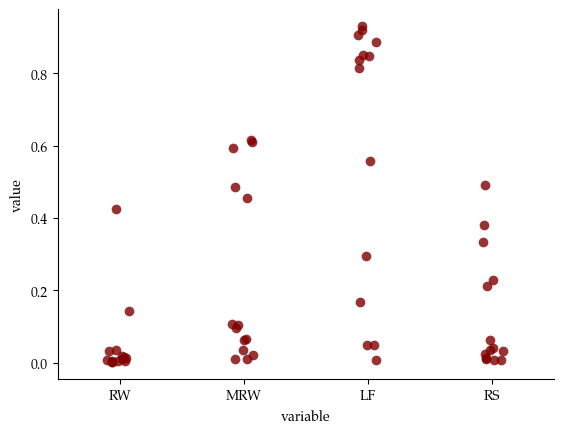

In [33]:
import pandas as pd
df_model_probs = pd.DataFrame(model_probs, columns=['RW', 'MRW', 'LF', 'RS'])
df_model_probs = pd.melt(df_model_probs, value_vars=['RW', 'MRW', 'LF', 'RS'])
sns.stripplot(data=df_model_probs, x="variable", y="value",
              color='maroon', alpha=0.8, size=7)
sns.despine()